# **Evaluation Function**

In [1]:
video_L = None
video_R = None
snapshot_L = None
snapshot_R = None

def evaluate(model, batch):
    global video_L, video_R, snapshot_L, snapshot_R
    
    # 0) Convert to Gray
    def rgb_to_gray(x):
        weights = torch.tensor([0.2989, 0.5870, 0.1140], dtype=x.dtype, device=x.device)
        gray = (x * weights[None, None, :, None, None]).sum(dim=2)
        return gray # -- shape: [B, T, H, W]
    
    video_L = rgb_to_gray(batch["img"][:, :, 0]) # ~ (b, t, h, w)
    video_R = rgb_to_gray(batch["img"][:, :, 1]) # ~ (b, t, h, w)
    
    # 1) Extract and normalize input videos.
    # -- min_max_norm = lambda x : 2. * (x / 255.) - 1.
    min_max_norm = lambda x: x / 255.
    video_L = min_max_norm(video_L) # ~ (b, t, h, w)
    video_R = min_max_norm(video_R) # ~ (b, t, h, w)
    
    # 2) If the tensor is non-contiguous and we try .view() later, PyTorch will raise an error:
    video_L = video_L.contiguous()
    video_R = video_R.contiguous()
    
    # 3) Coded exposure modeling.
    snapshot_L = model.sci_enc_L(video_L) # ~ (b, c, h, w) -- c=2 for 2 taps
    snapshot_R = model.sci_enc_R(video_R) # ~ (b, c, h, w) -- c=2 for 2 taps
    
    # 4) Dynamic Stereo
    output = {}
    
    disparities = model.stereo(
        snapshot_L,
        snapshot_R,
        iters=10,
        test_mode=False
    )

    snapshot_L = snapshot_L.detach().numpy()
    snapshot_R = snapshot_R.detach().numpy()
    
    return disparities, video_L, video_R, snapshot_L, snapshot_R

# **Model Setup and Testing on Dynamic Replica Dataset** 

In [2]:
import sys
import torch

sys.path.append("../")

import datasets.dynamic_stereo_datasets as datasets
from train import wrapper
from tqdm import tqdm

model = wrapper(sigma_range=[0, 1e-9],
                num_frames=8,
                in_channels=1,
                n_taps=2,
                resolution=[480, 640],
                mixed_precision=True,
                attention_type="self_stereo_temporal_update_time_update_space",
                update_block_3d=True,
                different_update_blocks=True,
                train_iters=8)

ckpt_path = "../dynamicstereo_sf_dr/model_dynamic-stereo_050895.pth"
state_dict = torch.load(ckpt_path, map_location=torch.device('cpu'))
model.load_state_dict(state_dict["model"], strict=True)
model.eval()

eval_dataloader_dr = datasets.DynamicReplicaDataset(
        split="valid", sample_len=8, only_first_n_samples=1, VERBOSE=False, root="../dynamic_replica_data", t_step_validation=2
    )

disparities_ls = []
video_L_ls = []
video_R_ls = []
snapshot_L_ls = []
snapshot_R_ls = []

for i in tqdm(range(0, 4)):
    batch = eval_dataloader_dr[i]
    batch["img"] = batch["img"].view(1, *batch["img"].shape)
    
    disparities, video_L, video_R, snapshot_L, snapshot_R = evaluate(model, batch)
    
    disparities_ls += [disparities]
    video_L_ls += [video_L]
    video_R_ls += [video_R]
    snapshot_L_ls += [snapshot_L]
    snapshot_R_ls += [snapshot_R]
    

seq_len e0ff8f-3_obj 300
seq_len ff80e8-3_obj 300
seq_len 216ba3-3_obj 300
seq_len 445120-3_obj 300
seq_len f14caa-3_obj 300
seq_len 151c87-3_obj 300
seq_len b0b6e8-3_obj 300
seq_len 7a54cd-3_obj 300
seq_len 927ad1-3_obj 300
seq_len a5e772-3_obj 300
seq_len e35334-3_obj 300
seq_len 7bf8c1-3_obj 300
seq_len b907d5-3_obj 300
seq_len acb880-3_obj 300
seq_len 8118b0-3_obj 300
seq_len 6e9561-3_obj 300
seq_len 0cde48-3_obj 300
seq_len 3c30ce-3_obj 300
seq_len 75643c-3_obj 300
seq_len 06dcf6-3_obj 300
Added 20 from Dynamic Replica valid


100%|████████████████████████████████████████████████████████████████████| 4/4 [01:10<00:00, 17.70s/it]


#### **Select Squence to be Visualized**

In [52]:
sel_idx = 0 # -- 0/1/2/3

disparities = disparities_ls[sel_idx].detach().cpu()
video_L = video_L_ls[sel_idx]
video_R = video_R_ls[sel_idx]
snapshot_L = snapshot_L_ls[sel_idx]
snapshot_R = snapshot_R_ls[sel_idx]

## **Disparity Maps (Left Aligned)**

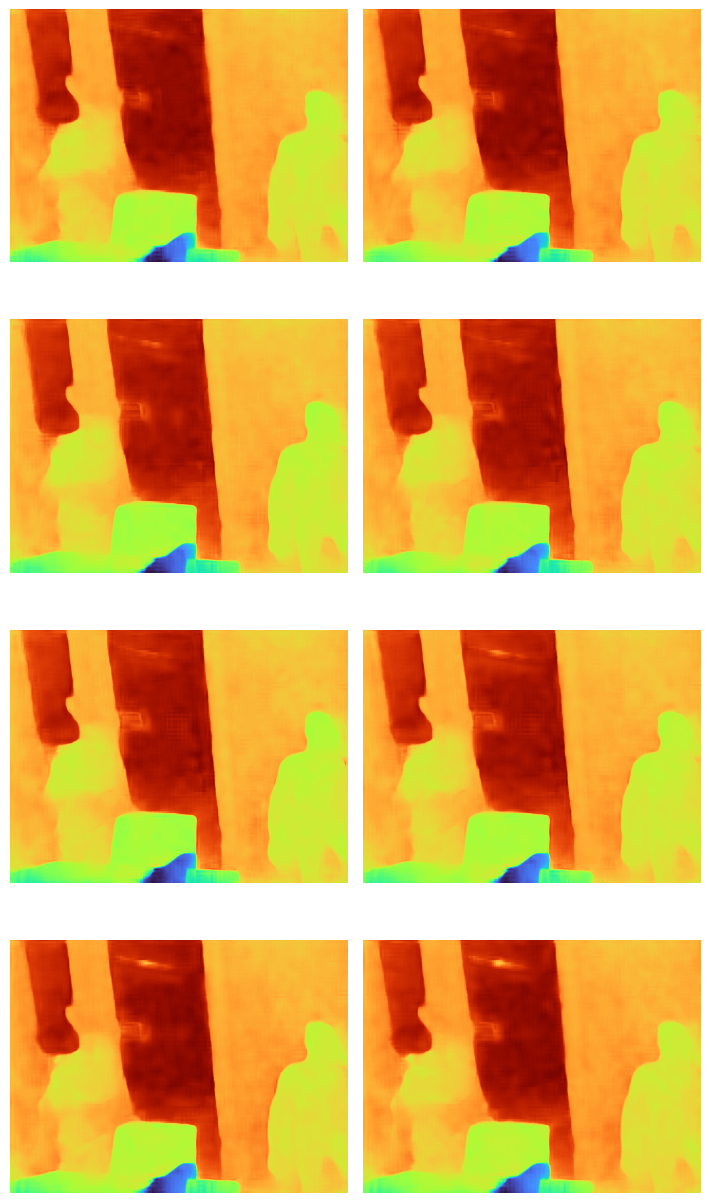

In [53]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(4, 2, figsize=(7.2, 12.8))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(disparities[-1, i, 0, 0], cmap="turbo")
    ax.axis("off")
plt.tight_layout()
plt.show()

In [61]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

disparity = disparities[-1, :, 0, 0].detach().numpy()

frames = []

for t in range(disparity.shape[0]):
    disp = disparity[t]

    # Normalize to 0–255 for visualization
    disp_norm = (disp - disp.min()) / (disp.max() - disp.min())
    disp_uint8 = (disp_norm * 255).astype(np.uint8)

    # Convert colormap to RGB image
    cmap = plt.get_cmap("turbo")  # or 'plasma', 'magma', etc.
    rgb = (cmap(disp_uint8)[:, :, :3] * 255).astype(np.uint8)

    frames.append(rgb)

# Save GIF (duration is time per frame in seconds)
# imageio.mimsave("disparity.gif", frames, duration=0.2)
imageio.mimsave(
    "disparity.mp4",
    frames,
    fps=30,
    codec="libx264",    # high-quality H.264 video
)

# **Video (Left View)**

torch.Size([1, 8, 720, 1280])


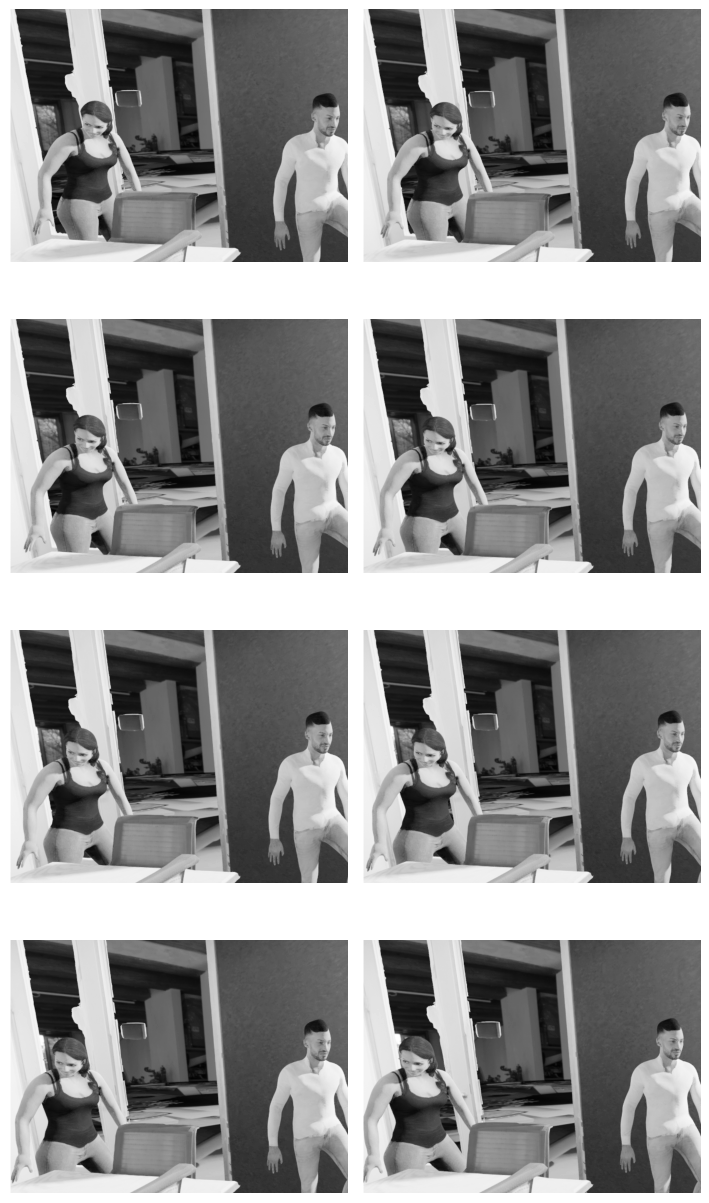

In [55]:
fig, axes = plt.subplots(4, 2, figsize=(7.2, 12.8))

print (video_L.shape)
for i, ax in enumerate(axes.flatten()):
    ax.imshow(video_L[0, i, ..., :480, :640], cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()

In [63]:
import numpy as np
import imageio

# disparity: numpy array with shape (8, 480, 640)

frames = []

for t in range(8):
    frame = video_R[0, t, ..., :480, :640].detach().numpy()

    # Normalize to 0–255
    # norm = (frame - frame.min()) / (frame.max() - frame.min())
    img = (frame * 255).astype(np.uint8)

    frames.append(img)

# Save as grayscale GIF
# imageio.mimsave("left_view.gif", frames, duration=0.2)
imageio.mimsave(
    "right_view.mp4",
    frames,
    fps=30,
    codec="libx264",    # high-quality H.264 video
)


# **Video (Right View)**

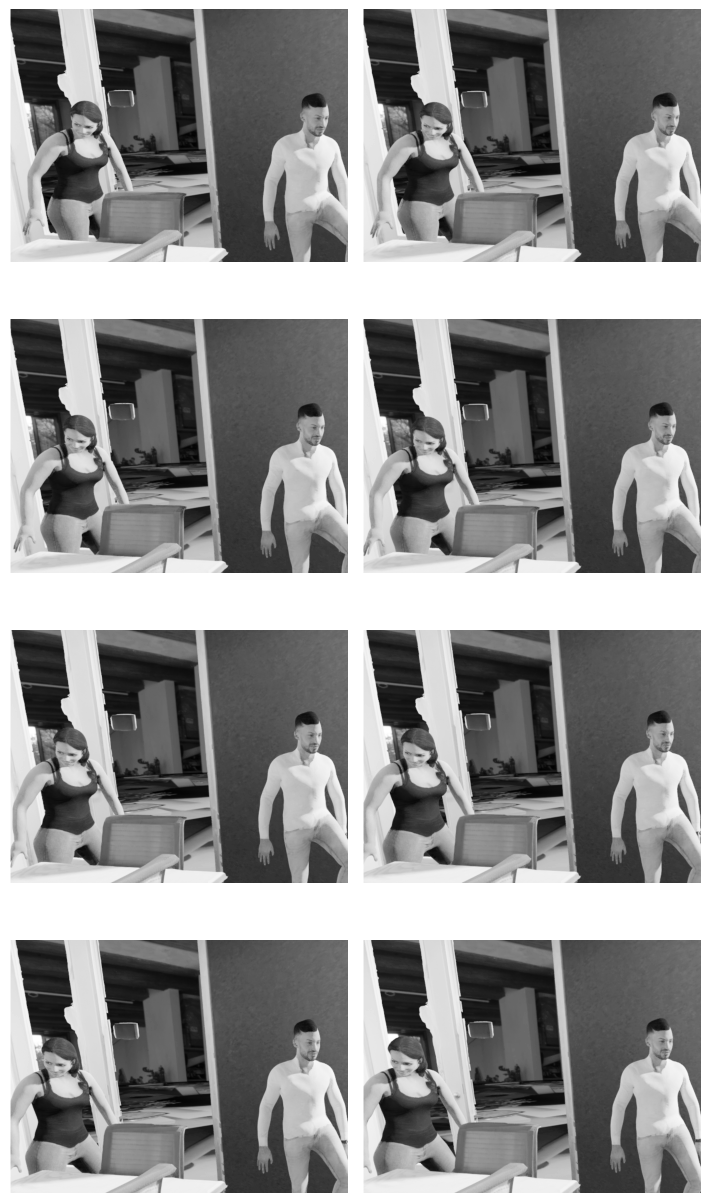

In [57]:
fig, axes = plt.subplots(4, 2, figsize=(7.2, 12.8))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(video_R[0, i, ..., :480, :640], cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()

# **Snapshots and Shutter Code (Left View)**

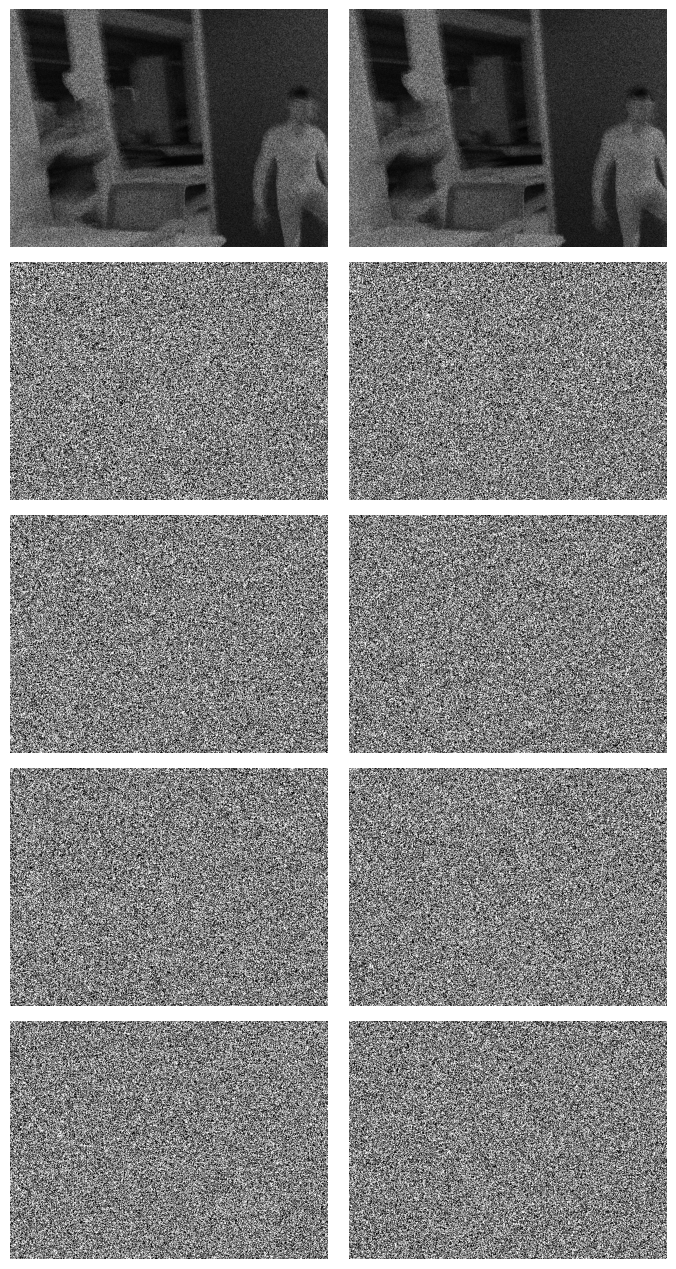

In [58]:
fig, axes = plt.subplots(5, 2, figsize=(7.2, 12.8))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(snapshot_L[0, i], cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()

# **SCI Encoder's Weights (Left)**

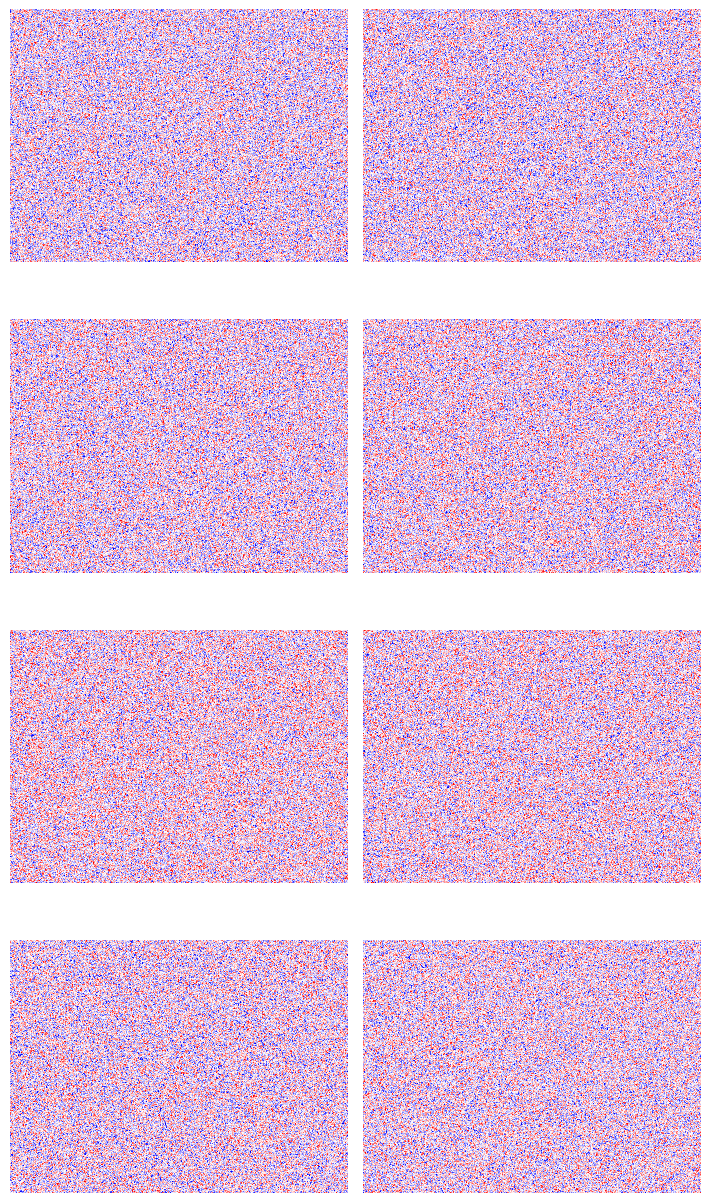

In [59]:
fig, axes = plt.subplots(4, 2, figsize=(7.2, 12.8))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(model.sci_enc_L.ce_weight.detach().numpy()[i, 0], cmap="seismic")
    ax.axis("off")
plt.tight_layout()
plt.show()

# **Snapshots and Shutter Code (Right View)**

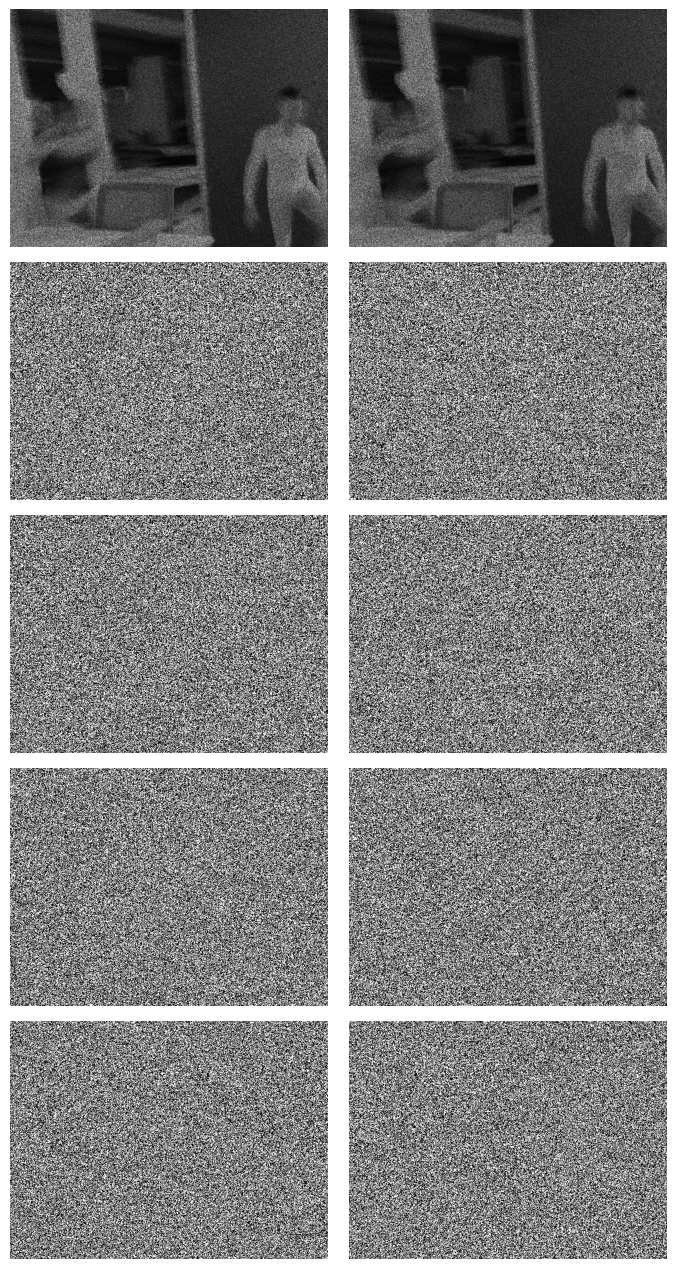

In [60]:
fig, axes = plt.subplots(5, 2, figsize=(7.2, 12.8))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(snapshot_R[0, i], cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()

# **SCI Encoder's Weights (Right)**

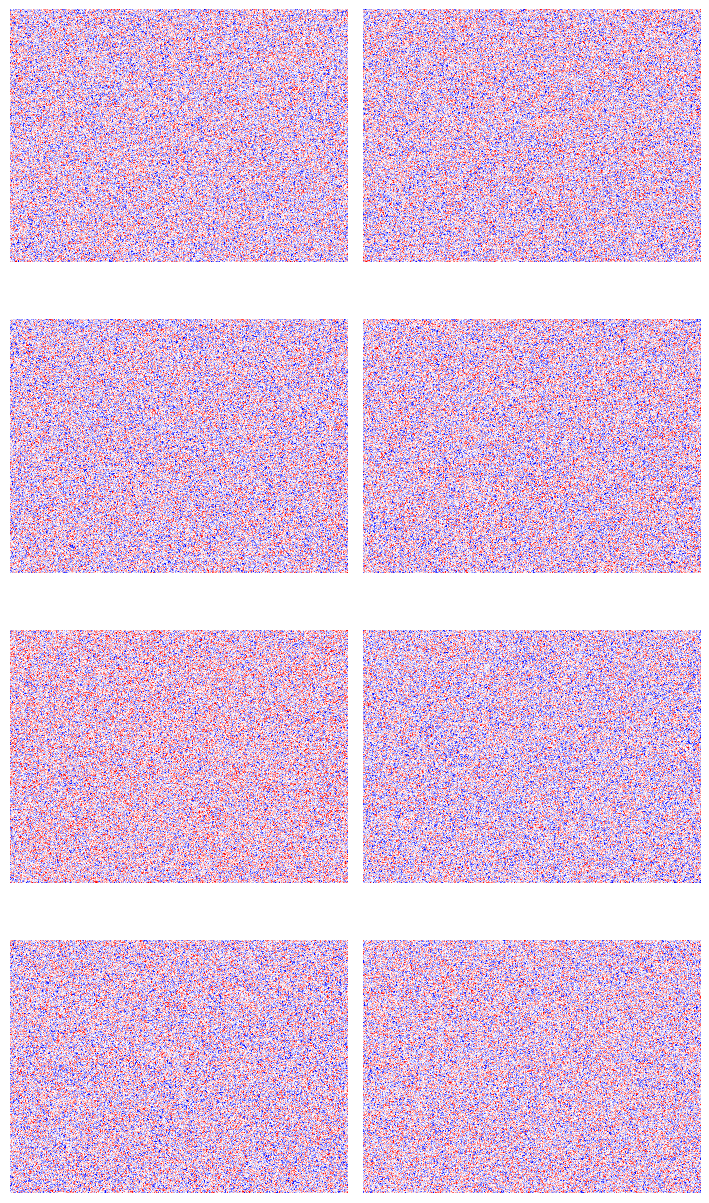

In [18]:
fig, axes = plt.subplots(4, 2, figsize=(7.2, 12.8))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(model.sci_enc_R.ce_weight.detach().numpy()[i, 0], cmap="seismic")
    ax.axis("off")
plt.tight_layout()
plt.show()